In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'

# from jax import config
# config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import plotly.io as pio
pio.renderers.default = "browser"

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import hj_reachability as hj

from dyn_sys.MzNonlinearCar import MzNonlinearCar


In [2]:
dynamics = MzNonlinearCar()

# limits of the grid in degrees
x1_lim = 150
x2_lim = 60

x1_lim = x1_lim * jnp.pi / 180
x2_lim = x2_lim * jnp.pi / 180

grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(np.array([-x1_lim, -x2_lim]),
                                                                           np.array([x1_lim, x2_lim])),
                                                                           (500, 500))
values = -jnp.linalg.norm(grid.states[..., :2], axis=-1) + 5 * jnp.pi / 180  # radius in radians
initial_values = values

solver_settings = hj.SolverSettings.with_accuracy(
    "very_high",
    hamiltonian_postprocessor=hj.solver.identity,
)



times = np.linspace(0, -0.5, 1000)

In [3]:
target_values = hj.solve_vi(solver_settings, dynamics, grid, times, values, initial_values)
# solver_settings = hj.SolverSettings.with_accuracy(
#     "very_high",
#     hamiltonian_postprocessor=hj.solver.backwards_reachable_tube,
# )
# target_values = hj.solve(solver_settings, dynamics, grid, times, initial_values)

100%|##########|  0.5000/0.5 [00:10<00:00, 20.43s/sim_s]


In [4]:
plot_time_index = len(times) // 1

<Figure size 640x480 with 0 Axes>

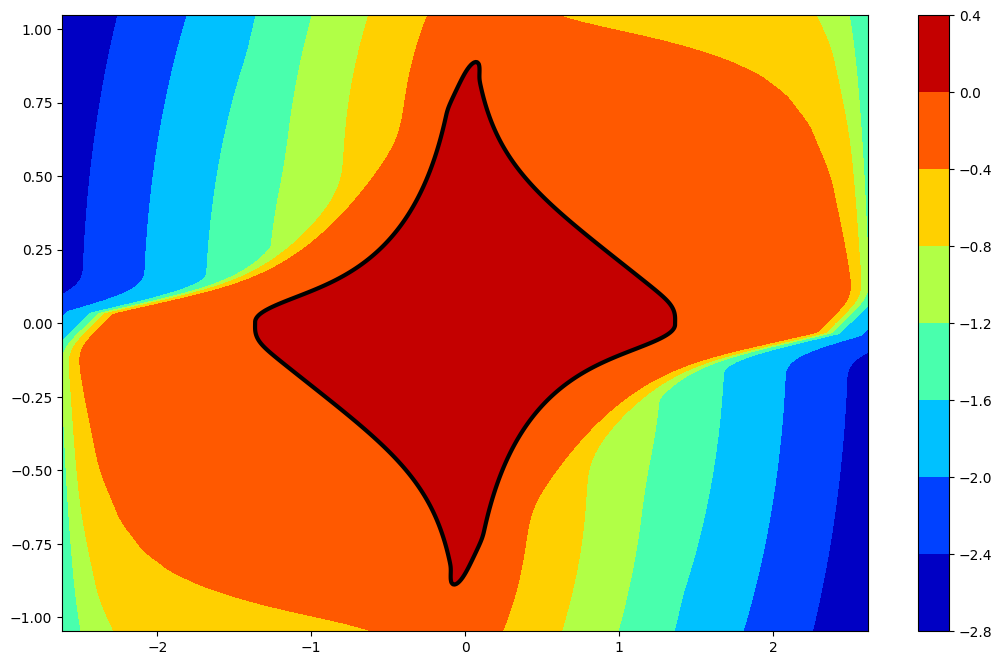

In [5]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[plot_time_index, :, :].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[plot_time_index, :, :].T,
            levels=0,
            colors="black",
            linewidths=3)

In [6]:
f = go.Figure(data=go.Surface(z=target_values[plot_time_index, :, :].T,
                                         x=grid.coordinate_vectors[0],
                                         y=grid.coordinate_vectors[1],
                                         colorscale="Jet",
                                         contours={
                                             "z": {
                                                 "show": True,
                                                 "start": -0.01,
                                                 "end": 0.01,
                                                 "size": 1
                                             }
                                         }))
f.update_layout(title="Reachable Set for MzNonlinearCar",
                  scene=dict(xaxis_title="x1",
                             yaxis_title="x2",
                             zaxis_title="value"),
                  width=800,
                  height=800)
f.show()